In [1]:
import os 
os.listdir("/kaggle/input/raw-paper")

['test', 'train']

In [2]:
os.listdir("/kaggle/input/raw-paper/train")

['Leprosy Lepromatous',
 'Darier_s Disease',
 'Pityriasis Rosea',
 'pigmented benign keratosis',
 'Hailey-Hailey Disease',
 'Melanoma',
 'Lupus Erythematosus Chronicus Discoides',
 'vascular lesion',
 'Tinea Corporis',
 'Mycosis Fungoides',
 'Papilomatosis Confluentes And Reticulate',
 'Lichen Planus',
 'actinic keratosis',
 'squamous cell carcinoma',
 'Neurofibromatosis',
 'Leprosy Tuberculoid',
 'Basal Cell Carcinoma',
 'Porokeratosis Actinic',
 'Impetigo',
 'Epidermolysis Bullosa Pruriginosa',
 'Herpes Simplex',
 'Tinea Nigra',
 'Pediculosis Capitis',
 'Molluscum Contagiosum',
 'seborrheic keratosis',
 'dermatofibroma',
 'Psoriasis',
 'Tungiasis',
 'Leprosy Borderline',
 'nevus',
 'Larva Migrans']

In [3]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from PIL import Image
import torch
import os
import pandas as pd

# Load the pre-trained model and image processor
repo_name = "Jayanth2002/swin-base-patch4-window7-224-rawdata-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name, output_hidden_states=True)

# Define the directory containing test images
test_dir = "/kaggle/input/raw-paper/train"


In [ ]:
# Initialize lists to store original and predicted class indices
original_class_indices = []
predicted_class_indices = []

# Initialize a dictionary to store prediction scores for each class
class_prediction_scores = {}

# Create a list to store the unique class labels
unique_class_labels = []

# Loop through each image in the test directory
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    
    # Initialize a list to store prediction scores for this class
    class_scores = []
    
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        
        # Load and preprocess the input image
        image = Image.open(image_path)
        encoding = image_processor(image, return_tensors="pt")

        # Make predictions
        with torch.no_grad():
            outputs = model(**encoding)
            logits = outputs.logits

        # Get the predicted class index
        predicted_class_idx = logits.argmax(-1).item()
        
        # Append the results to the lists
        original_class_indices.append(class_name)
        predicted_class_indices.append(predicted_class_idx)
        
        # Append the prediction score to the class_scores list
        class_scores.append(logits[0].tolist())
    
    # Store the class_scores list in the dictionary with class_name as the key
    class_prediction_scores[class_name] = class_scores
    
    # Add the class label to the unique_class_labels list
    unique_class_labels.append(class_name)

# Create a DataFrame to store the original and predicted class indices
results_df = pd.DataFrame({
    "Original_Class_Index": original_class_indices,
    "Predicted_Class_Index": predicted_class_indices
})

In [ ]:
class_index_to_name = {idx: name for idx, name in enumerate(os.listdir(test_dir))}

In [ ]:
class_index_to_name

In [ ]:
#Test Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x="Original_Class_Index", y="Predicted_Class_Index", order=unique_class_labels)
plt.xticks(rotation=90)
plt.title("Box Plots of Original vs. Predicted Classes")
plt.xlabel("Original Class")
plt.ylabel("Predicted Class")
plt.yticks(range(len(unique_class_labels)), unique_class_labels)  # Custom y-axis ticks
plt.show()

# Create Violin Plots to compare original and predicted classes
plt.figure(figsize=(12, 6))
sns.violinplot(data=results_df, x="Original_Class_Index", y="Predicted_Class_Index", order=unique_class_labels)
plt.xticks(rotation=90)
plt.title("Violin Plots of Original vs. Predicted Classes")
plt.xlabel("Original Class")
plt.ylabel("Predicted Class")
plt.yticks(range(len(unique_class_labels)), unique_class_labels)  # Custom y-axis ticks
plt.show()

In [ ]:
print("hello")

TSNE TEST

In [4]:
import torch

# Initialize lists to store image embeddings and class labels
image_embeddings = []
class_labels = []

# Loop through each image in the test dataset
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)

    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)

        # Load and preprocess the input image
        image = Image.open(image_path)
        encoding = image_processor(image, return_tensors="pt")

        # Get the feature representation (embedding) from the model
        with torch.no_grad():
            outputs = model(**encoding)
            embeddings = outputs.hidden_states[-1].mean(dim=1)  # Use the mean of hidden states as the embedding

        # Append the embedding and class label to the lists
        image_embeddings.append(embeddings.numpy())
        class_labels.append(class_name)


In [5]:
import numpy as np
image_embeddings_np = np.vstack(image_embeddings)

In [6]:
from sklearn.manifold import TSNE

# Flatten the list of embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(image_embeddings_np)


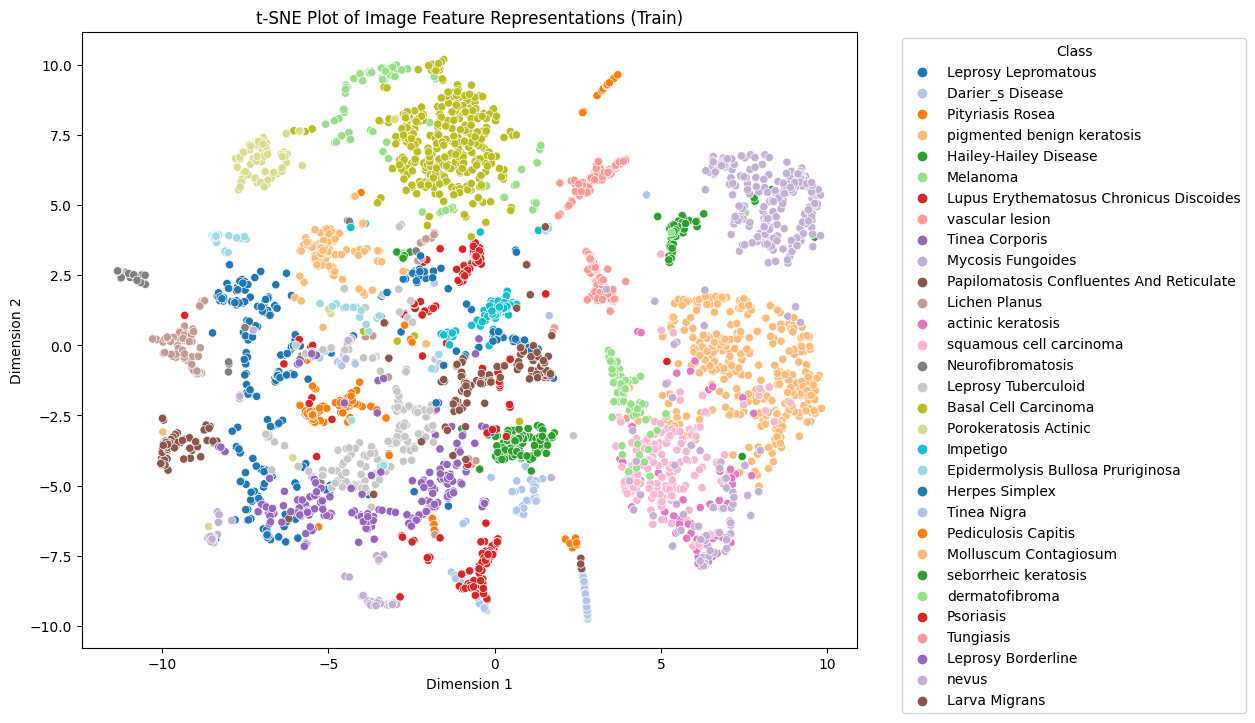

In [13]:
import pandas as pd

# Create a DataFrame to store t-SNE embeddings and class labels
tsne_df = pd.DataFrame({
    "Dimension 1": tsne_embeddings[:, 0],
    "Dimension 2": tsne_embeddings[:, 1],
    "Class": class_labels
})

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=tsne_df, x="Dimension 1", y="Dimension 2", hue="Class", palette="tab20")
plt.title("t-SNE Plot of Image Feature Representations (Train)")

# Move the legend to the right side of the figure
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns